Library Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import random
from cv2 import resize
from glob import glob
import requests
from io import BytesIO

Dataset split

In [2]:
img_height = 244
img_width = 244
train_ds = tf.keras.utils.image_dataset_from_directory('./Faulty_solar_panel/Faulty_solar_panel',
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  './Faulty_solar_panel/Faulty_solar_panel',
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

Found 885 files belonging to 6 classes.
Using 708 files for training.
Found 885 files belonging to 6 classes.
Using 177 files for validation.


In [3]:
# Checking the Classes 
class_names = train_ds.class_names
print(class_names)
train_ds

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

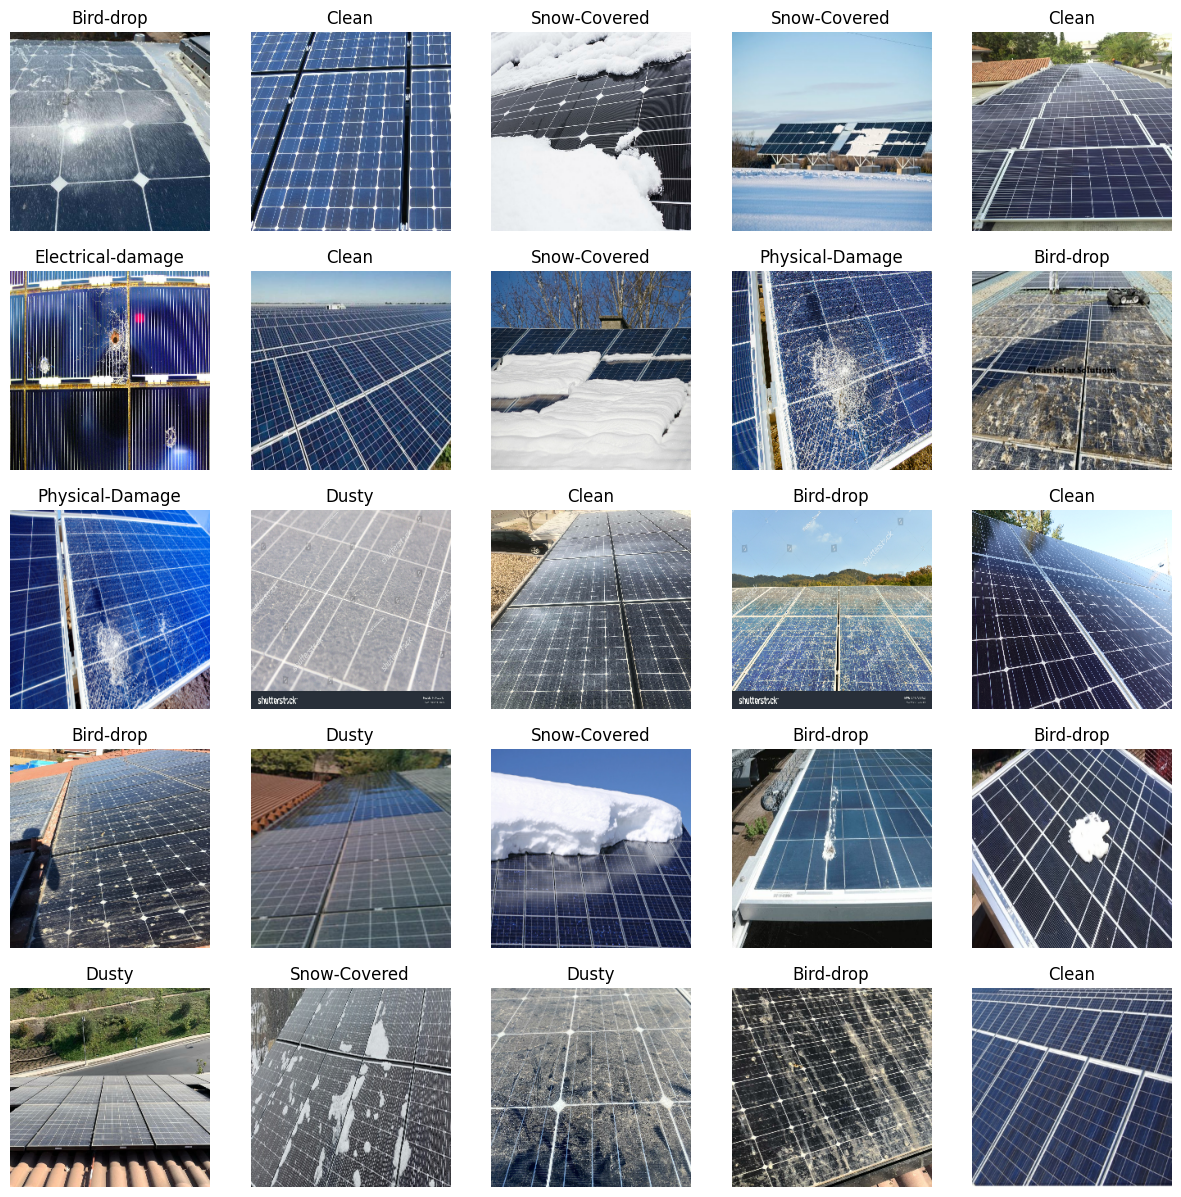

In [4]:
# Checking Training Data
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Model definition

In [5]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False 

In [6]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(90)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 244, 244)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 244, 244)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 244, 244)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 244, 244,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 244, 244,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 90)        │     46,170 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,760,858 (56.31 MB)

 Trainable params: 46,170 (180.35 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model Training

In [8]:
epoch = 20
model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.0669 - loss: 12.4296 - val_accuracy: 0.3390 - val_loss: 4.1444
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.2993 - loss: 5.2559 - val_accuracy: 0.4237 - val_loss: 2.6528
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3905 - loss: 3.6451 - val_accuracy: 0.5141 - val_loss: 2.0007
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4732 - loss: 2.7472 - val_accuracy: 0.5254 - val_loss: 1.7227
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5183 - loss: 2.2178 - val_accuracy: 0.6045 - val_loss: 1.4273
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5691 - loss: 1.9644 - val_accuracy: 0.6102 - val_loss: 1.2869
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6415 - loss: 1.5269 - val_accuracy: 0.6610 - val_loss: 1.1989
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6646 - loss: 1.4665 - val_accuracy: 0.7062 - val_loss

In [9]:
# fine tuning
base_model.trainable = True
for layer in base_model.layers[:14]:
    layer.trainable = False
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 244, 244)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 244, 244)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 244, 244)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 244, 244,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 244, 244,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 90)        │     46,170 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,853,200 (56.66 MB)

 Trainable params: 7,125,594 (27.18 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 92,342 (360.71 KB)

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
epoch = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
        )
    ]
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7472 - loss: 0.8209 - val_accuracy: 0.7458 - val_loss: 0.7647
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8736 - loss: 0.4019 - val_accuracy: 0.8249 - val_loss: 0.6411
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9361 - loss: 0.1892 - val_accuracy: 0.7910 - val_loss: 0.6541
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9753 - loss: 0.0922 - val_accuracy: 0.8023 - val_loss: 0.7789
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9837 - loss: 0.0727 - val_accuracy: 0.7910 - val_loss: 0.7206
Epoch 5: early stopping


Model Evaluation

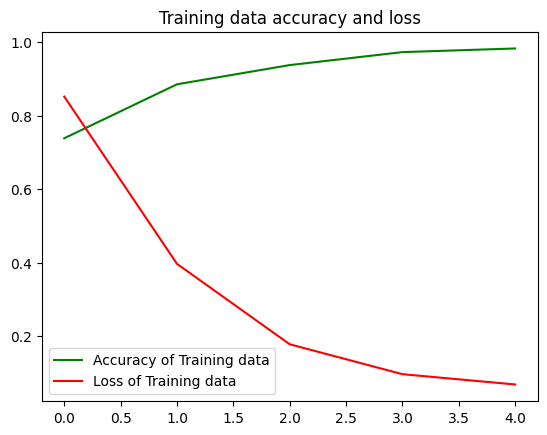

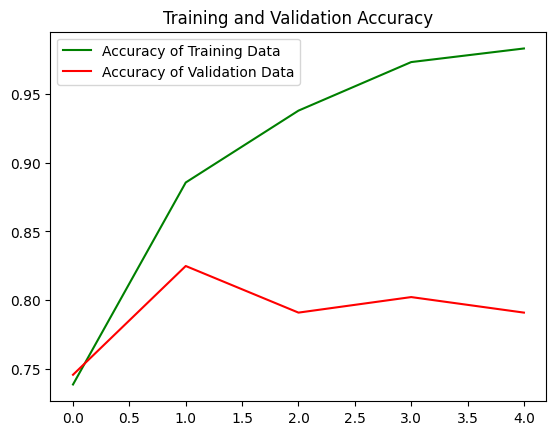

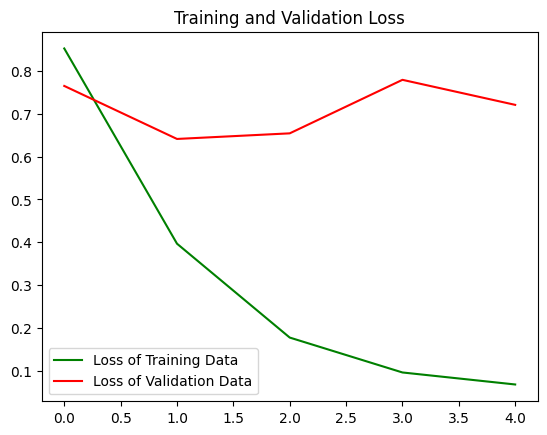

<Figure size 640x480 with 0 Axes>

In [12]:
get_ac = history.history['accuracy']
get_los = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7986 - loss: 0.6563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


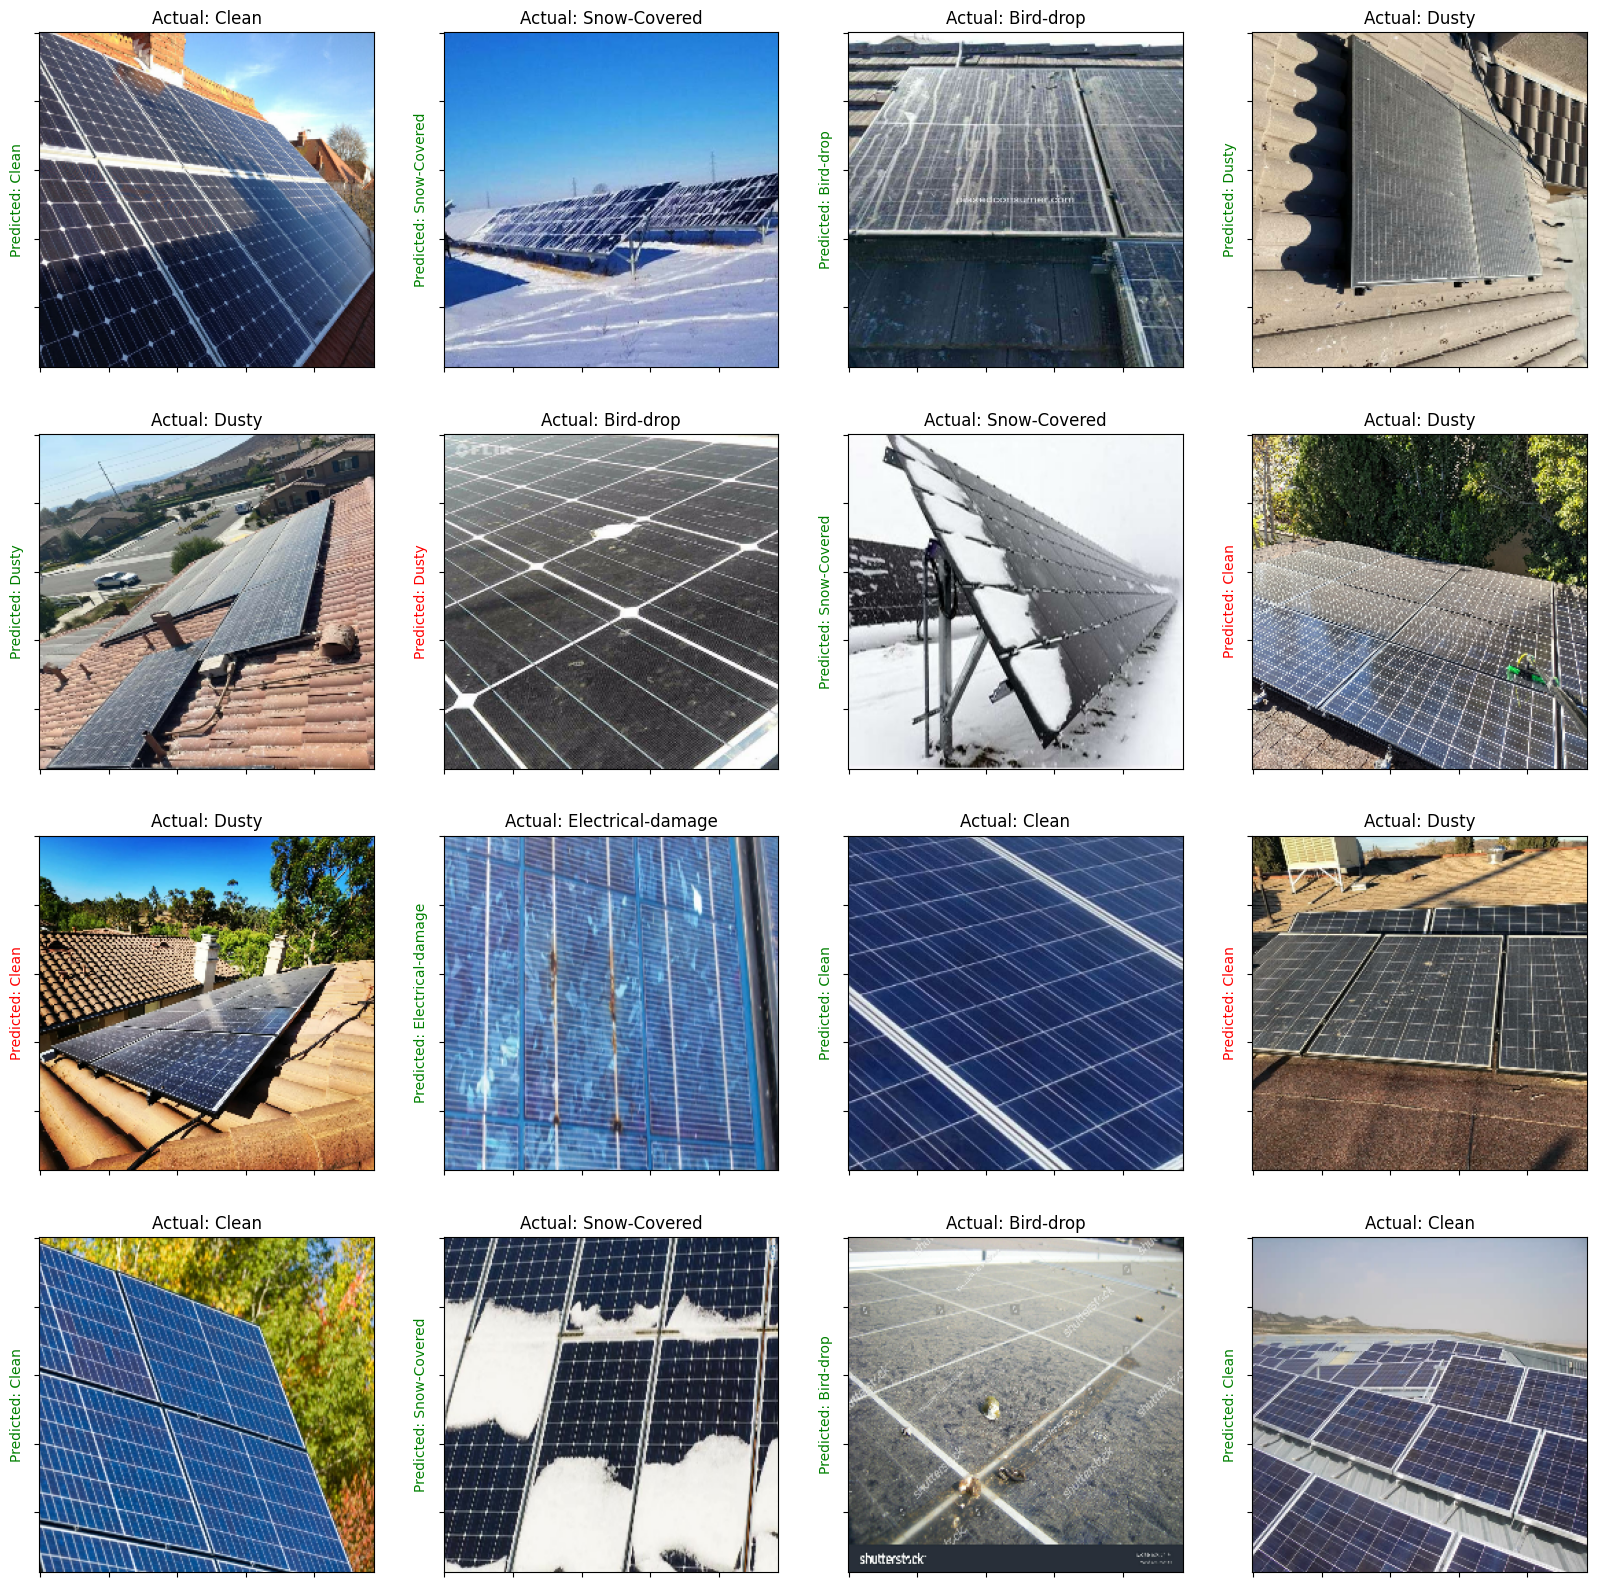

In [13]:
loss, accuracy = model.evaluate(val_ds)

plt.figure(figsize=(20, 20))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

Using model for prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted label: Electrical-damage


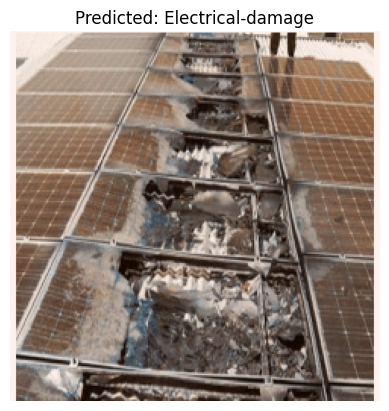

In [18]:
#testing
img_path = 'Faulty_solar_panel/test_images/test_1.png'

# Load the image with the target size
img_height = 244
img_width = 244
img = image.load_img(img_path, target_size=(img_height, img_width))

def model_predict(tf_img,trained_model):
    # Convert the image to a numpy array
    img_array = image.img_to_array(tf_img)

    # Add an extra dimension to the image (required for model input)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocess the image using VGG16's preprocess_input function
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    
    # Predict the class using the model
    predictions = trained_model.predict(img_array)
    
    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)
    
    # Map the predicted class index to the class label
    predicted_label = class_names[predicted_class[0]]
    
    # Print the predicted label
    print(f"Predicted label: {predicted_label}")
    
    # Plot the image with the predicted label
    plt.imshow(image.array_to_img(img_array[0]))
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

model_predict(img,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Predicted label: Clean


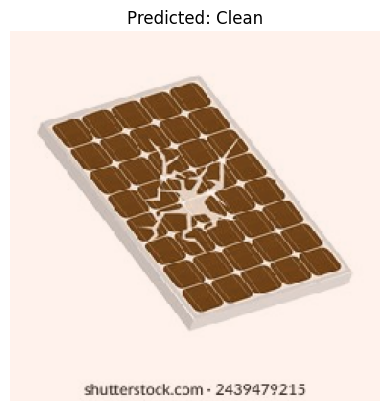

In [19]:
#From a web source
# Define the URL of the image
img_url ='https://www.shutterstock.com/image-vector/cracked-solar-panel-vector-illustration-260nw-2439479215.jpg'

# Download the image
response = requests.get(img_url)
img = image.load_img(BytesIO(response.content), target_size=(img_height, img_width))

model_predict(img,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predicted label: Dusty


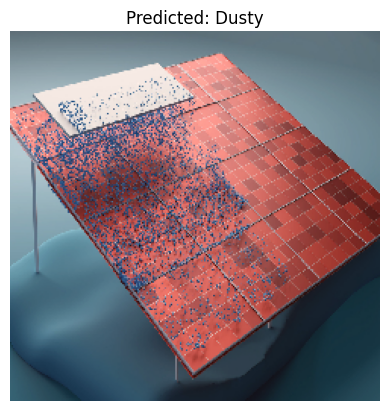

In [20]:
img_url ='https://news.mit.edu/sites/default/files/styles/news_article__image_gallery/public/images/202203/MIT-Cleaning-Solar-01-press_0.jpg'
response = requests.get(img_url)
img = image.load_img(BytesIO(response.content), target_size=(img_height, img_width))

model_predict(img,model)

Exporting and using the model

In [21]:
# Save the model
model.save('SolarPanel_VGG16_Model.keras')

In [22]:

# Load the model with custom objects
loaded_model = tf.keras.models.load_model('SolarPanel_VGG16_Model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Predicted label: Dusty


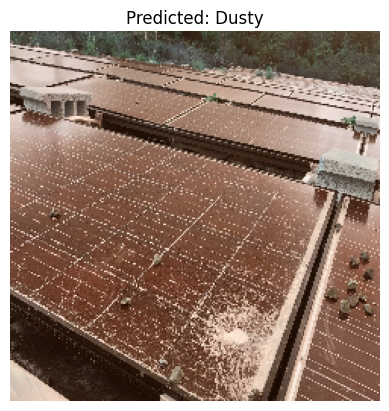

In [23]:
# Define the URL of the image
img_url = 'https://img.huffingtonpost.com/asset/5cabd3dd230000f4006daddc.jpeg'

# Download the image
response = requests.get(img_url)
img = image.load_img(BytesIO(response.content), target_size=(img_height, img_width))

model_predict(img,loaded_model)